In [9]:
%load_ext autoreload
%autoreload 2

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
import kuaizi
kuaizi.set_matplotlib(style='nature', usetex=False)

In [7]:
import fsps
import sedpy
import prospect
from prospect.sources.constants import cosmo
import exspect
import sys
sys.path.append('/Users/jiaxuanl/Dropbox (Princeton)/Research/popsed/')

In [428]:
from popsed import mock
from popsed.sfh import params_to_sfh, parametric_sfr, parametric_mwa

In [262]:
# SDSS filters
sdss = ['sdss_{0}0'.format(b) for b in 'ugriz']

In [333]:
# we start with a simple model: tau-SFH, no dust attenuation and emission, no nebular emission
# we only vary stellar mass and tau.
model = mock.build_model(mass=5e10, zred=0.05, 
                         tage=cosmo.age(0.05).value, tau=2.5, 
                         sfh=1, add_dustabs=False,
                         uniform_priors=True)
sfr = parametric_sfr(times=np.array([0]), **model.params, tavg=0.05) # current SFR, avg = 50 Myr
model.params['sfr'] = sfr
model.params['ssfr'] = model.params['sfr'] / model.params['mass']

For this simple $\tau$ model, we have (assuming all stellar mass is formed in this way)
$$ \mathrm{SFR}(t_0) = \frac{M}{\tau (e^{t_0/\tau} - 1)}$$

$$ \mathrm{sSFR}(t_0) = \frac{1}{\tau (e^{t_0/\tau} - 1)}$$

Text(0, 0.5, '$\\rm sSFR$ (Gyr$^{-1}$)')

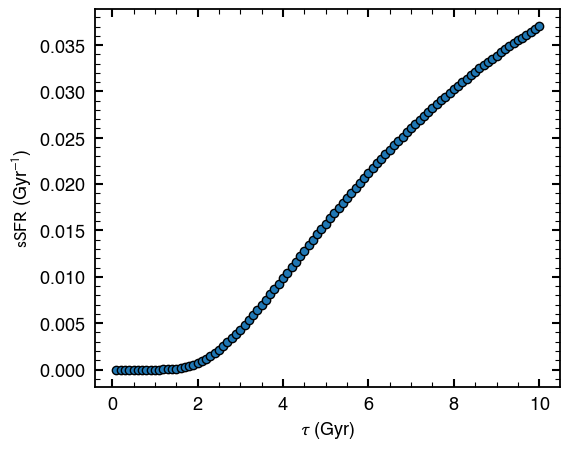

In [343]:
taus = np.linspace(0.1, 10, 100)
ssfr = 1 / (taus) / (np.exp(13.088 / taus) - 1)

plt.scatter(taus, ssfr)
plt.xlabel(r'$\tau$ (Gyr)')
plt.ylabel(r'$\rm sSFR$ (Gyr$^{-1}$)')

#plt.yscale('log')
#plt.ylim(1e-4, 0)

In [429]:
# Sample the stellar mass -- SFR plane
sfr_set = []
mass_set = []
mwa_set = []
tau_set = []

for mass in np.logspace(9, 12, 10):
    for tau in 1 / np.logspace(-1, 0., 20): #np.linspace(0.1, 10, 15):#np.logspace(-0.3, 1.2, 15):
        model = mock.build_model(mass=mass, zred=0.05, 
                                 tage=cosmo.age(0.05).value, tau=tau, 
                                 sfh=1, add_dustabs=False,
                                 uniform_priors=True)
        sfr = parametric_sfr(times=np.array([0]), **model.params, tavg=0.05) # current SFR, avg = 50 Myr
        sfr_set.append(float(sfr))
        mass_set.append(mass)
        mwa_set.append(parametric_mwa(tau=tau, tage=cosmo.age(0.05).value))
        tau_set.append(tau)

Text(0, 0.5, '$\\log\\ \\mathrm{SFR}\\ [M_\\odot\\ \\rm{yr}^{-1}]$')

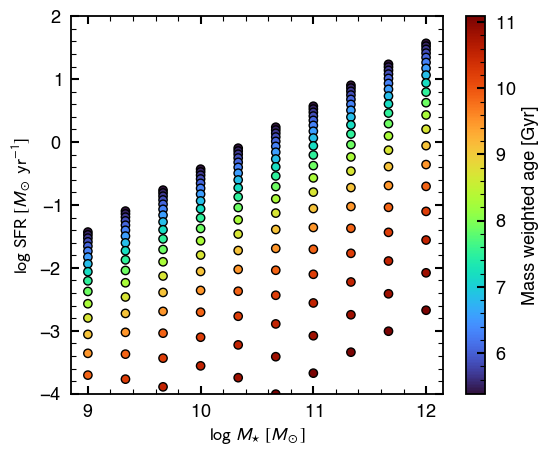

In [431]:
plt.scatter(np.log10(mass_set), np.log10(sfr_set), c=mwa_set)
plt.colorbar(label='Mass weighted age [Gyr]')
plt.ylim(-4, 2)

plt.xlabel(r'$\log\ M_{\star}\ [M_\odot]$')
plt.ylabel(r'$\log\ \mathrm{SFR}\ [M_\odot\ \rm{yr}^{-1}]$')

In [278]:
obs = mock.build_obs(mass=5e10, zred=0.05, 
                     tage=10.5, tau=2.5, 
                     sfh=1, uniform_priors=True, 
                     snr_spec=0, snr_phot=20, 
                     filterset=sdss, 
                     continuum_optimize=False)

In [286]:
obs['mag'] = - 2.5 * np.log10(obs['maggies'])

In [287]:
obs

{'filters': [<class 'sedpy.observate.Filter'>(sdss_u0),
  <class 'sedpy.observate.Filter'>(sdss_g0),
  <class 'sedpy.observate.Filter'>(sdss_r0),
  <class 'sedpy.observate.Filter'>(sdss_i0),
  <class 'sedpy.observate.Filter'>(sdss_z0)],
 'maggies': array([3.37686360e-08, 1.27722465e-07, 2.63780479e-07, 3.61100123e-07,
        4.87853372e-07]),
 'wavelength': None,
 'spectrum': None,
 'true_spectrum': array([ 1.98100691e-11, -2.23148934e-14, -3.64478533e-16, ...,
         6.96854098e-10,  6.78473902e-10,  6.41099710e-10]),
 'true_maggies': array([2.97431270e-08, 1.23833278e-07, 2.52325296e-07, 3.52227070e-07,
        4.72471634e-07]),
 'mock_params': {'zred': array([0.05]),
  'mass': array([5.e+10]),
  'logzsol': array([-0.5]),
  'dust2': array([0.6]),
  'sfh': array([1]),
  'tage': array([10.5]),
  'imf_type': array([2]),
  'dust_type': array([0]),
  'tau': array([2.5])},
 'maggies_unc': array([1.48715635e-09, 6.19166391e-09, 1.26162648e-08, 1.76113535e-08,
        2.36235817e-08]),
 '

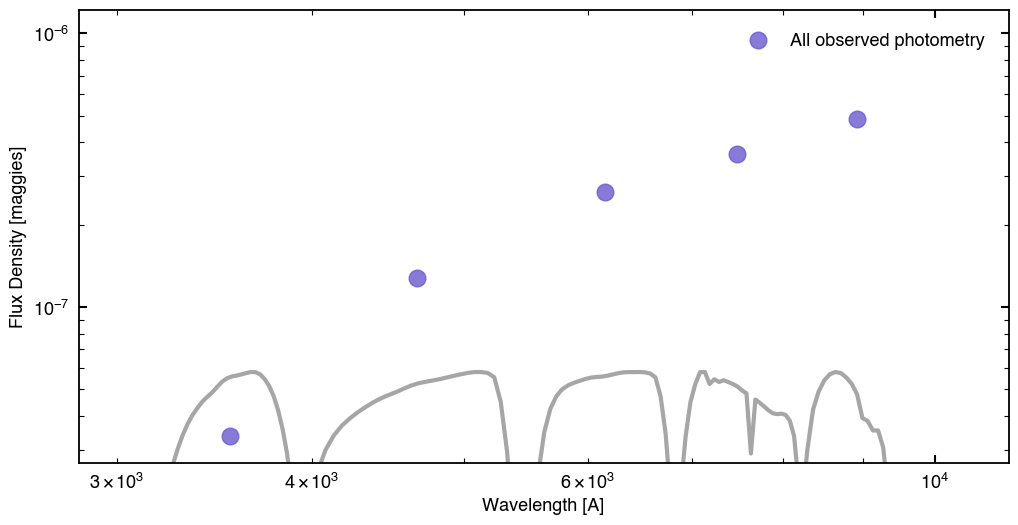

In [289]:
# --- Plot the Data ----
# This is why we stored these...
wphot = obs["phot_wave"]

# establish bounds
xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
ymin, ymax = obs["maggies"].min()*0.8, obs["maggies"].max()/0.4
plt.figure(figsize=(12, 6))

# plot all the data
plt.plot(wphot, obs['maggies'],
     label='All observed photometry',
     marker='o', markersize=12, alpha=0.8, ls='', lw=3,
     color='slateblue')

# plot Filters
for f in obs['filters']:
    w, t = f.wavelength.copy(), f.transmission.copy()
    t = t / t.max()
    t = 10**(0.2*(np.log10(ymax/ymin)))*t * ymin
    plt.loglog(w, t, lw=3, color='gray', alpha=0.7)
    
# prettify
plt.xlabel('Wavelength [A]')
plt.ylabel('Flux Density [maggies]')
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
#plt.xscale("log")
plt.yscale("log")
plt.legend(loc='best')

In [232]:
# t, sfr, cmf = params_to_sfh(model.params, 
#                             time=np.linspace(0, cosmo.age(model.params['zred']).value, 30), 
#                             agebins=None)